# Garbage Classification Using Transfer Learning

## Project Overview

This notebook presents a comparative study of **Convolutional Neural Networks (CNNs)** and **Transfer Learning architectures** for multi-class garbage image classification. The goal is to evaluate how modern pretrained models perform against a custom CNN baseline under a consistent training and evaluation pipeline.

The project is designed with a **portfolio-oriented, production-aware mindset**, emphasizing clarity, reproducibility, and engineering best practices. Rather than focusing on academic novelty, the notebook showcases practical model development, benchmarking, and deployment-readiness — ideal for real-world applications and professional review.

This task reflects real-world challenges in **waste management and environmental monitoring**, where accurate image classification can support automation, sustainability, and smart infrastructure.

## Objectives

- Load and preprocess an image-based garbage classification dataset  
- Apply data augmentation to improve generalization  
- Build a baseline CNN model trained from scratch  
- Apply transfer learning using multiple pretrained architectures  
- Train and validate models using a consistent pipeline  
- Evaluate model performance using accuracy and loss metrics  
- Compare performance across models using identical preprocessing and training strategies  
- Analyze results and highlight trade-offs between accuracy and efficiency  
- Identify the most deployment-ready model balancing accuracy, speed, and resource efficiency

### Libraries and Dependencies

This section imports all required Python libraries used throughout the notebook.
TensorFlow/Keras is used for deep learning, while supporting libraries handle
numerical operations, visualization, and file system interaction.


In [1]:
# Importing libraries
import os
import time
import splitfolders
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers

# 1. Explore and Prepare the Dataset

In [2]:
data_dir = ('dataset')
classes_names = os.listdir(data_dir) # Extract class folder names as labels
classes_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [3]:
# Split the dataset into train, validation, and test sets (70%, 20%, 10%)
splitfolders.ratio("dataset", output="dataset", seed=42, ratio=(.7, .2, .1))

Copying files: 20212 files [00:46, 437.79 files/s]


# 2. Visualizing the Dataset

Representative samples from the dataset were visualized to gain intuition about image quality, variability, and potential challenges. Class distributions and example images provided context for model development.

In [4]:
classes_dir = 'dataset/train'
image_classes = os.listdir(classes_dir) # List of class names from training set


def plot_images(image_classes):
    """
    Display one sample image from each class in the training dataset.

    Parameters
    ----------
    image_classes : list of str
        Class names corresponding to subdirectories under 'dataset/train'.

    Returns
    -------
    None
        Displays a matplotlib figure with normalized images arranged in a grid.
    """

    plt.figure(figsize=(15,5))

    for i,category in enumerate(image_classes):
        image_path=classes_dir + '/' + category        # Creaitng category path
        images_in_class=os.listdir(image_path)         # List images in the class

        f_image=images_in_class[0]
        f_image_path=image_path + '/' + f_image        # Full path to image
    
        img=image.load_img(f_image_path)               # Load image
        img_array=image.img_to_array(img)/255          # Normalize pixels values
 
        plt.subplot(2,5,i+1)                           # Create subplot
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')                                # Hide axes

    plt.show()

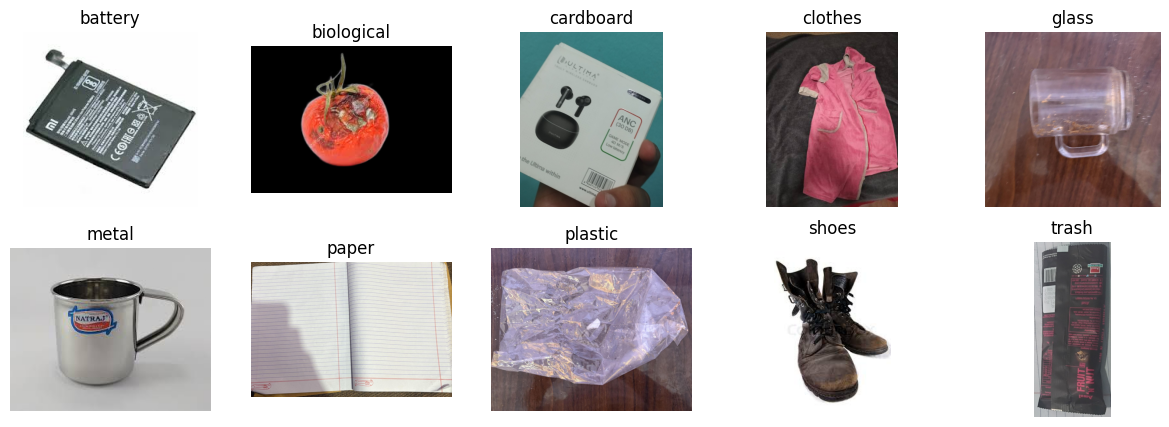

In [5]:
# Display the figure
plot_images(image_classes)

# 3. Preprocess and Load Data

Data preprocessing pipelines were implemented, including resizing, normalization, and augmentation. The dataset was then loaded into TensorFlow/Keras `tf.data` pipelines for efficient training and validation workflows.

### Global Configuration

Defines global hyperparameters and dataset-related configurations.
These values control image resolution, batch size, and training duration.

In [6]:
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

# Number of images processed per batch
BATCH_SIZE = 8

# Image dimensions and input shapes expected by the pretrained network
IMG_SIZE = (180, 180)
input_shape = (180,180, 3)

In [8]:
def prepare_data_pipeline(
    train_dir,
    val_dir,
    test_dir,
    img_size=(224, 224),
    batch_size=32,
    model_type='scratch'
):
    """
    Builds a TensorFlow data pipeline for image classification tasks.

    Parameters
    ----------
    train_dir : str
        Path to the training image directory.
    val_dir : str
        Path to the validation image directory.
    test_dir : str
        Path to the test image directory.
    img_size : tuple, default (244, 244)
        Target image size (height, width) for resizing.
    batch_size : int, default 32
        Number of images per batch.
    model_type : str, default scratch
        Type of model to use; affects preprocessing.
                     Options: 'scratch', 'resnet50', 'mobilenetv2', 'efficientnetb0'.

    Returns
    -------
    train_ds, val_ds, test_ds : tuple
        Each a tf.data.Dataset object with preprocessing, 
                augmentation (for training), caching, and prefetching applied.
    """

    # Load training dataset from directory with shuffling and categorical labels
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=True
    )

    # Load validation dataset without shuffling
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=False
    )

    # Load test dataset without shuffling
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=False
    )

    # Select preprocessing function based on model type
    if model_type == "resnet50":
        preprocess_fn = resnet_preprocess
    elif model_type == "mobilenetv2":
        preprocess_fn = mobilenet_preprocess
    elif model_type == "efficientnetb0":
        preprocess_fn = efficientnet_preprocess
    else:  # CNN from scratch
        preprocess_fn = lambda x: x / 255.0

    # Define data augmentation pipeline for training images
    data_augmentation = Sequential([
        tf.keras.layers.RandomFlip("horizontal"), # Random horizontal flip
        tf.keras.layers.RandomRotation(0.1),      # Random rotation up to ±10%
        tf.keras.layers.RandomZoom(0.1),          # Random zoom up to ±10%
    ])

    # Preprocessing function applied to each batch
    def process(images, labels, training=False):
        images = preprocess_fn(images)
        if training:
            images = data_augmentation(images)
        return images, labels

    # Apply preprocessing and augmentation to training datase
    train_ds = (
        train_ds
        .map(lambda x, y: process(x, y, training=True),
             num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .prefetch(tf.data.AUTOTUNE)
    )

    # Apply preprocessing to validation dataset (no augmentation)
    val_ds = (
        val_ds
        .map(lambda x, y: process(x, y, training=False),
             num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .prefetch(tf.data.AUTOTUNE)
    )

    # Apply preprocessing to test dataset (no augmentation)
    test_ds = (
        test_ds
        .map(lambda x, y: process(x, y, training=False),
             num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )

    return train_ds, val_ds, test_ds

# 4. Model Development

Multiple architectures were developed and benchmarked to compare performance across scratch and transfer learning approaches.  
Utility functions such as `enable_fine_tuning` and `get_callbacks` were introduced to streamline fine‑tuning workflows and ensure consistent training management.

In [9]:
def enable_fine_tuning(
    model,
    base_model,
    unfreeze_layers=20,
    learning_rate=1e-5
):
    """
    Enables fine-tuning for a pretrained convolutional backbone within a full classification model.

    Parameters
    ----------
    model : tf.keras.Model 
        The complete model including the classifier head.
    base_model : tf.keras.model 
        The pretrained feature extractor (e.g., ResNet50, MobileNetV2).
    unfreeze_layers : int, default 20 
        Number of top layers in the base model to unfreeze for training
    learning_rate : float, default 1e-5 
        Learning rate for the fine-tuning phase.

    Returns
    -------
        tf.keras.Model : The compiled model ready for fine-tuning.
    """

    # Set the entire base model to be trainable
    base_model.trainable = True

    # Freeze all layers except the top `unfreeze_layers` layers
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    # Compile the full model with a low learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [10]:
def get_callbacks(model_name):
    """
    Constructs a list of Keras callbacks to optimize training and manage model checkpoints.

    Parameters
    ----------
    model_name : str
        Identifier used to name the saved model file.

    Returns
    -------
    callbacks : list
        A list of tf.keras.callbacks including EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint.
    """
    
    # Define a list of callbacks to be used during training
    # Stop training if validation loss doesn't improve for 5 epochs; restore best weights
    # Reduce learning rate by factor of 0.2 if validation loss stagnates for 3 epochs
    # Save the best model based on validation performance to the specified path
    callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2),
    ModelCheckpoint(f"models/{model_name}_best.h5", save_best_only=True)
    ]
    return callbacks

## 4.1 Scratch CNN

- **Architecture**: A custom CNN was built from scratch with four convolutional blocks, global pooling, and dense layers.
- **Evaluation**: The model was trained and evaluated, highlighting the limitations of scratch training on limited data.
- **Visualizations**: Accuracy and loss curves were plotted to analyze convergence and generalization.

### **Architecture**

Defines a custom CNN model from scratch for baseline benchmarking.

In [11]:
def build_cnn_model(num_classes, input_shape):
    """
    Build a custom CNN model from scratch for image classification.

    Parameters
    ----------
    num_classes : int
        Number of output classes for classification.
    input_shape : tuple of int
        Shape of input images, e.g., (224, 224, 3).

    Returns
    -------
    model : keras.Sequential
        Compiled CNN model ready for training.
    """
    
    model = Sequential()

    model.add(Input(shape=input_shape)) # Explicit input layer

    # Block 1: Conv → BN → Pool → Dropout
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3)) # Regularization
    
    # Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3)) # Regularization
    
    # Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3)) # Regularization
    
    # Block 4
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3)) # Regularization
    
    # Global average pooling
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Regularization
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
train_ds, val_ds, test_ds = prepare_data_pipeline(
    train_dir,
    val_dir,
    test_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 14142 files belonging to 10 classes.
Found 4038 files belonging to 10 classes.
Found 2032 files belonging to 10 classes.


#### Model Complexity Overview

This section summarizes the architectural and computational characteristics of the custom CNN model built from scratch.

| Component                  | Description                                                  |
|---------------------------|--------------------------------------------------------------|
| **Architecture**          | 4 Conv blocks → GlobalAvgPool → Dense(256) → Dropout → Softmax |
| **Conv Blocks**           | Each block includes Conv2D → BatchNorm → MaxPooling → Dropout |
| **Trainable Parameters**  | ~2.5M                                                        |
| **Total Parameters**      | ~2.5M                                                        |
| **Input Shape**           | `(height, width, channels)` — e.g., `(224, 224, 3)`           |
| **Output Classes**        | `num_classes` (e.g., 10 for multiclass classification)        |
| **Regularization**        | Dropout (0.3 in Conv blocks, 0.5 in Dense layer)              |
| **Optimizer**             | Adam (`learning_rate=1e-3`)                                   |
| **Loss Function**         | Categorical Crossentropy                                      |
| **Metrics**               | Accuracy                                                      |

> Note: This model is designed for interpretability and control, offering full customization of architecture and training behavior. Ideal for benchmarking against pretrained backbones.

In [13]:
# Build the CNN model
cnn_model = build_cnn_model(num_classes=10, input_shape=input_shape)

# Display the model architecture, layer types, output shapes, and parameter counts
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,0

 Total params: 459,722 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [14]:
# Record the start time to measure total training duration
start_time = time.time()

In [15]:
# Train the CNN model using the prepared training and validation datasets
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('cnn_scratch')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2733 - loss: 2.4525  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 537s 300ms/step - accuracy: 0.3195 - loss: 2.1804 - val_accuracy: 0.3442 - val_loss: 2.1848 - learning_rate: 0.0010
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3780 - loss: 1.8550  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 499s 282ms/step - accuracy: 0.3886 - loss: 1.8096 - val_accuracy: 0.3685 - val_loss: 2.0928 - learning_rate: 0.0010
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.4082 - loss: 1.7381   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 600s 340ms/step - accuracy: 0.4180 - loss: 1.7099 - val_accuracy: 0.4393 - val_loss: 1.6463 - learning_rate: 0.0010
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 592s 335ms/step - accuracy: 0.4381 - loss: 1.6459 - val_accuracy: 0.1736 - val_loss: 3.6676 - learning_rate: 0.0010
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 580s 328ms/step - accuracy: 0.4615 - loss: 1.5730 - val_accuracy: 0.4312 - val_loss: 1.7269 - learning_rate: 0.0010


In [16]:
# Record the end time after training completes
end_time = time.time()

# Calculate total training duration in seconds
train_time_cnn = end_time - start_time

In [68]:
print(f"Training time: {train_time_cnn:.2f} seconds")

Training time: 2808.87 seconds


### **Scratch CNN Evaluation**

Evaluates model predictions using classification report and raw confusion matrix (numeric).

In [18]:
# Evaluate model on test set
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"Scratch CNN Test Loss: {test_loss}")
print(f"Scratch CNN Test Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.4326 - loss: 1.6987
Scratch CNN Test Loss: 1.6987273693084717
Scratch CNN Test Accuracy: 43.26%


In [19]:
# Generate predictions and compute evaluation metrics
y_pred_cnn = cnn_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Confusion matrix and classification report
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
print(cm_cnn)
print('\n')
print(classification_report(y_true, y_pred_cnn))

254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step
[[ 39   6   2  20   0   0   6   1  20   2]
 [  0  58   2  23   6   0   6   2   4   0]
 [  0  30  77  33   8   0  13   5  12   8]
 [  2  11  13 437   1   0  62   7   1   0]
 [  1  52   5  71  60   0  59  19  23  31]
 [  1   7   5  38  10   0  37   0   8   2]
 [  1   6   8  58   4   0  83   3   6  11]
 [  0  14  10  82  15   0  42  25   4  18]
 [ 16   8   3  87   1   0  20   1  59   4]
 [  0  11   3  16   1   0  18   5   2  41]]


              precision    recall  f1-score   support

           0       0.65      0.41      0.50        96
           1       0.29      0.57      0.38       101
           2       0.60      0.41      0.49       186
           3       0.51      0.82      0.62       534
           4       0.57      0.19      0.28       321
           5       0.00      0.00      0.00       108
           6       0.24      0.46      0.32       180
           7       0.37      0.12      0.18       210
           8       0.42      0.30    

### **Scratch CNN Evaluation Visualizations**

- Visualizes the confusion matrix as a heatmap for intuitive class-wise performance analysis.
- Plots training and validation accuracy/loss over epochs to visualize learning dynamics.

<Axes: >

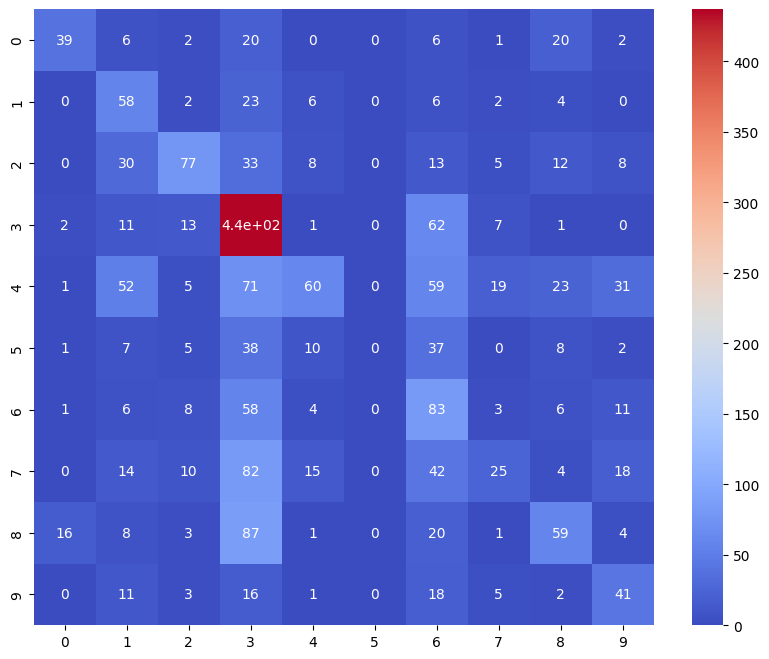

In [20]:
# Plot the confusion matrix as a heatmap for easier visual interpretation
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, cmap='coolwarm', annot=True)

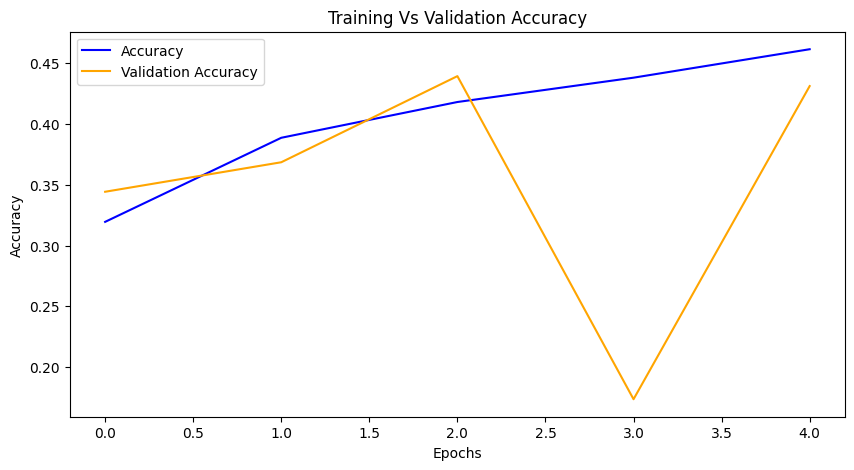

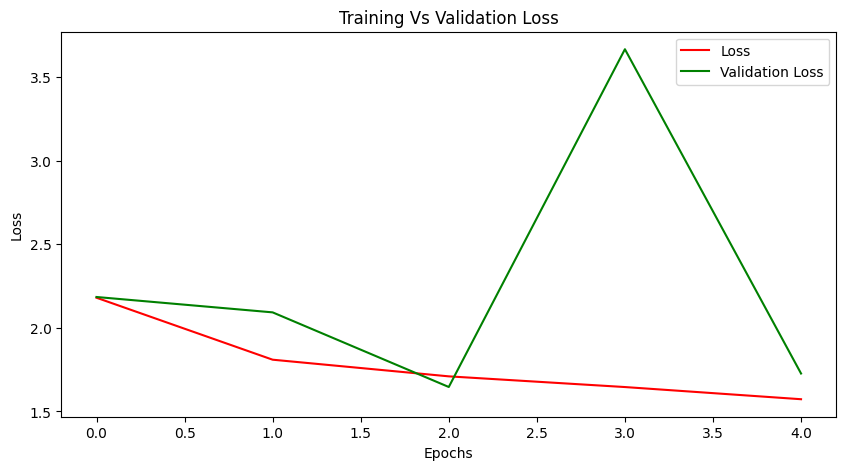

In [21]:
# CNN from scratch learning curves
# Plot training and validation accuracy and loss to visualize learning behavior

# ---- Accuracy curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='Loss', color='red')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.2 ResNet50

- **Architecture**: A ResNet50 backbone pretrained on ImageNet was adapted with a custom dense head.
- **Fine-Tuning**: Selected layers were unfrozen and retrained with a lower learning rate to improve performance.
- **Evaluation**: The fine-tuned model was benchmarked against scratch CNN.
- **Visualizations**: Training and validation curves were analyzed to assess convergence and stability.

### **Architecture**

Loads a pretrained ResNet50 model with frozen base layers and a custom classification head.

In [22]:
def build_resnet50_model(num_classes, input_shape, freeze_base=True):
    """
    Build a ResNet50-based image classification model with a custom dense head.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shape : tuple
        Shape of input images (height, width, channels).
    freeze_base : bool, default True
        Whether to freeze the pretrained ResNet50 backbone.

    Returns
    -------
    model : keras.Model
        Compiled Keras model ready for training.
    base_model : keras.Model
        The ResNet50 backbone (pretrained), useful for fine-tuning or inspection.
        
    """

    # Load pretrained ResNet50 backbone without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg',  input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = not freeze_base
    
    # Add new layers
    x = Dense(128, activation='relu')(base_model.output)
    x = Dropout(0.5)(x) # Regularization
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x) # Regularization

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)  # Adjust output neurons as needed
    
    # Define and compile the full model
    model = Model(inputs=base_model.input, outputs=output_layer)
    optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model

#### Model Complexity Overview

This section summarizes the architectural and computational characteristics of the ResNet50-based transfer learning model.

| Component                  | Description                                                  |
|---------------------------|--------------------------------------------------------------|
| **Backbone**              | ResNet50 (pretrained on ImageNet, `include_top=False`, `pooling='avg'`) |
| **Custom Head**           | Dense(128) → Dropout(0.5) → Dense(64) → Dropout(0.5) → Softmax |
| **Trainable Parameters**  | Depends on `freeze_base`; ~2M when frozen, ~25M when unfrozen |
| **Total Parameters**      | ~25.6M                                                       |
| **Input Shape**           | `(height, width, channels)` — e.g., `(180, 180, 3)`           |
| **Output Classes**        | `num_classes` (e.g., 10 for multiclass classification)        |
| **Regularization**        | Dropout (0.5) in both Dense layers                            |
| **Optimizer**             | Adam (`learning_rate=1e-3`)                                   |
| **Loss Function**         | Categorical Crossentropy                                      |
| **Metrics**               | Accuracy                                                      |

> Note: The model leverages deep pretrained features and is suitable for fine-tuning via `enable_fine_tuning()` to adapt to domain-specific data.

In [23]:
train_ds, val_ds, test_ds = prepare_data_pipeline(
    train_dir,
    val_dir,
    test_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    model_type='resnet50'
)

Found 14142 files belonging to 10 classes.
Found 4038 files belonging to 10 classes.
Found 2032 files belonging to 10 classes.


In [24]:
# Build the ResNet50 model
resnet50_model, base_model = build_resnet50_model(10, input_shape)

# Display the model architecture, layer types, output shapes, and parameter counts
resnet50_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 180, 180, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 186, 186, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 90, 90, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 90, 90, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 90, 90, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 92, 92, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 45, 45, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 45, 45, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 45, 45, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 45, 45, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 45, 45, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 45, 45, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 45, 45, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 45, 45, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 45, 45, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
# Record the start time to measure total training duration
start_time = time.time()

In [26]:
# Train the ResNet50 model using the prepared training and validation datasets
history_resnet50 = resnet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('resnet50')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5374 - loss: 1.4102   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1029s 577ms/step - accuracy: 0.6476 - loss: 1.0829 - val_accuracy: 0.8767 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7659 - loss: 0.7538   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1045s 591ms/step - accuracy: 0.7799 - loss: 0.7131 - val_accuracy: 0.8935 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7992 - loss: 0.6533   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1044s 591ms/step - accuracy: 0.8077 - loss: 0.6250 - val_accuracy: 0.9042 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8191 - loss: 0.5890   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 845s 478ms/step - accuracy: 0.8267 - loss: 0.5697 - val_accuracy: 0.9099 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8297 - loss: 0.5421   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 815s 461ms/step - accuracy: 0.8348 - loss: 0.5301 - val_accuracy: 0.9111 - val_loss: 0.3131 - learning_rate: 0.0010


In [27]:
# Record the end time after training completes
end_time = time.time()

# Calculate total training duration in seconds
train_time_resnet = end_time - start_time

In [69]:
print(f"Training time: {train_time_resnet50:.2f} seconds")

Training time: 4778.31 seconds


### **ResNet50 Fine-tuning**

Unfreezes selected layers and retrains with a lower learning rate to improve performance.

In [29]:
# Enable fine-tuning by unfreezing the top 20 layers of the base model
resnet50_model = enable_fine_tuning(
    resnet50_model,
    base_model,
    unfreeze_layers=20,
    learning_rate=1e-5
)

In [30]:
# Train the fine-tuned ResNet50 model for 5 epochs using callbacks
history_resnet50 = resnet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('resnet50')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8235 - loss: 0.5521   

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1079s 602ms/step - accuracy: 0.8372 - loss: 0.5144 - val_accuracy: 0.9195 - val_loss: 0.2994 - learning_rate: 1.0000e-05
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1038s 587ms/step - accuracy: 0.8669 - loss: 0.4148 - val_accuracy: 0.9225 - val_loss: 0.3067 - learning_rate: 1.0000e-05
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 1064s 600ms/step - accuracy: 0.8835 - loss: 0.3559 - val_accuracy: 0.9240 - val_loss: 0.3003 - learning_rate: 1.0000e-05
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 973s 550ms/step - accuracy: 0.8985 - loss: 0.3168 - val_accuracy: 0.9245 - val_loss: 0.3169 - learning_rate: 1.0000e-05
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 922s 522ms/step - accuracy: 0.9048 - loss: 0.2805 - val_accuracy: 0.9260 - val_loss: 0.3126 - learning_rate: 2.0000e-06


### **ResNet50 Evaluation**

Evaluates model predictions using classification report and raw confusion matrix (numeric) after fine-tuning.

In [31]:
# Evaluate model performance on the test set
test_loss, test_acc = resnet50_model.evaluate(test_ds)
print(f"ResNet50 Test Loss: {test_loss}")
print(f"ResNet50 Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - accuracy: 0.9124 - loss: 0.3027 
ResNet50 Test Loss: 0.3027035892009735
ResNet50 Accuracy: 91.24%


In [33]:
# Generate predictions and compute evaluation metrics
y_pred_resnet50 = resnet50_model.predict(test_ds)
y_pred_resnet50 = np.argmax(y_pred_resnet50, axis=1)

# Confusion matrix and classification report
cm_resnet50 = confusion_matrix(y_true, y_pred_resnet50)
print(cm_resnet50)
print('\n')
print(classification_report(y_true, y_pred_resnet50))

254/254 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step 
[[ 89   0   1   0   0   5   0   0   1   0]
 [  0  97   1   0   0   0   1   0   1   1]
 [  3   1 166   0   0   1  12   3   0   0]
 [  0   0   0 531   0   0   0   1   2   0]
 [  0   1   0   0 280  12   2  23   3   0]
 [  0   0   0   1   6  94   2   4   1   0]
 [  0   1   6   3   0   1 164   3   1   1]
 [  1   0   8   0  18   5   4 169   2   3]
 [  1   0   0   1   2   0   1   2 192   0]
 [  2   0   3   3   0   4   5   4   4  72]]


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        96
           1       0.97      0.96      0.97       101
           2       0.90      0.89      0.89       186
           3       0.99      0.99      0.99       534
           4       0.92      0.87      0.89       321
           5       0.77      0.87      0.82       108
           6       0.86      0.91      0.88       180
           7       0.81      0.80      0.81       210
           8       0.93      0.96  

### **ResNet50 Evaluation Visualizations**

- isualizes the confusion matrix as a heatmap for intuitive class-wise performance analysis.
- Plots training and validation accuracy/loss over epochs to visualize learning dynamics.

<Axes: >

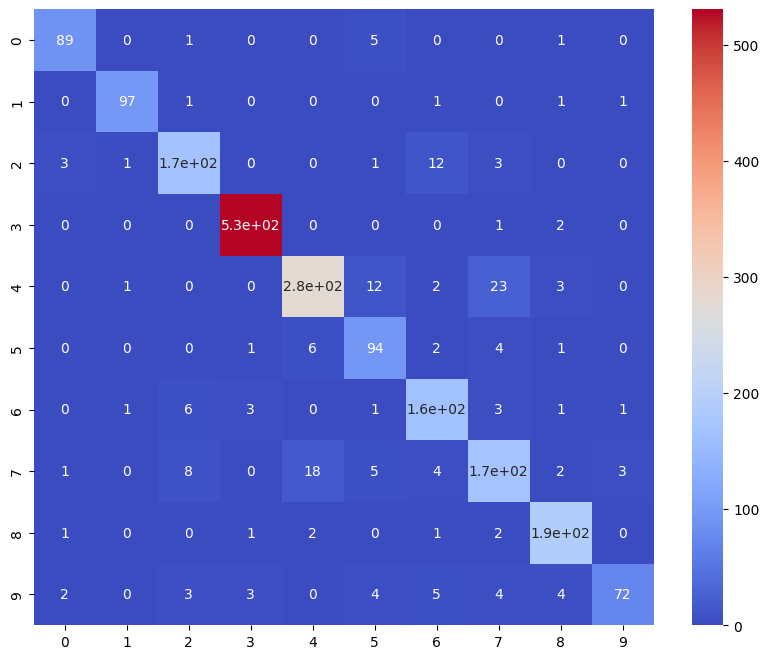

In [34]:
# Plot the confusion matrix as a heatmap for easier visual interpretation
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet50, cmap='coolwarm', annot=True)

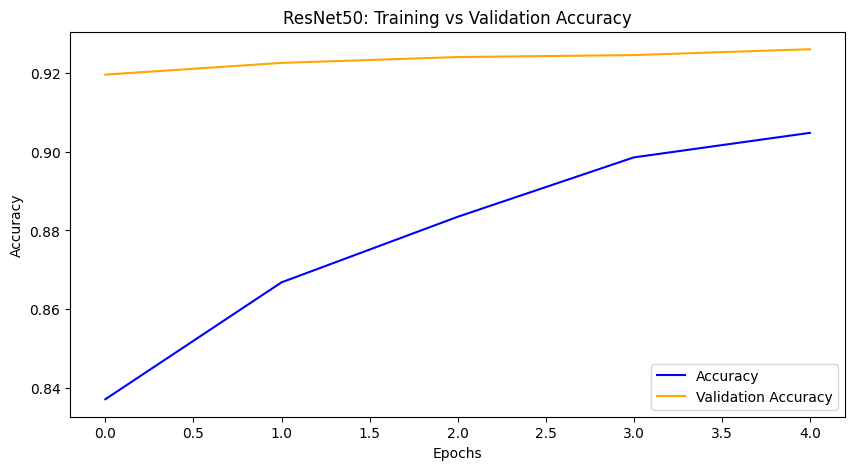

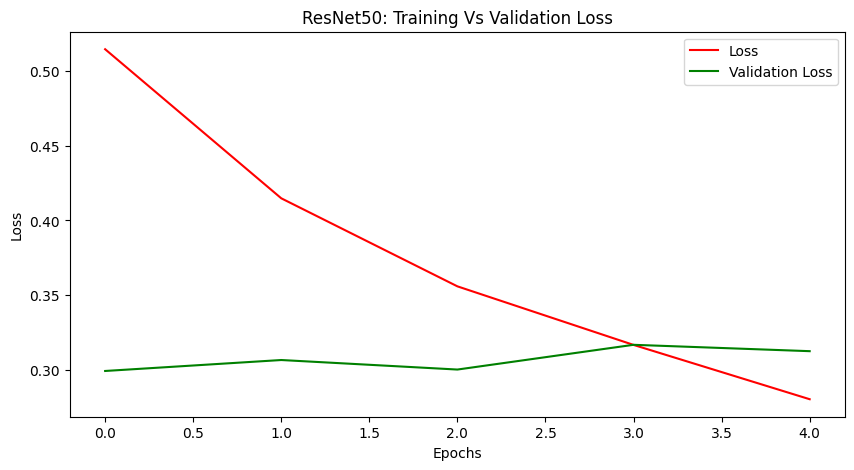

In [35]:
# ResNet50 Learning Curves
# Plot training and validation accuracy and loss to visualize learning behavior

# ---- Accuracy curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_resnet50.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('ResNet50: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_resnet50.history['loss'], label='Loss', color='red')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss', color='green')
plt.title('ResNet50: Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.3 MobileNetV2

- **Architecture**: MobileNetV2 was used as a lightweight backbone with a custom classification head.
- **Fine-Tuning**: Top layers were unfrozen and retrained to adapt features to the dataset.
- **Evaluation**: Performance was compared against ResNet50 and scratch CNN.
- **Visualizations**: Accuracy and loss plots demonstrated rapid convergence and efficiency.

### **Architecture**

Uses MobileNetV2 for lightweight deployment scenarios.

In [36]:
def build_mobilenetv2_model(num_classes, input_shape, freeze_base=True):
    """
    Build a transfer learning model using MobileNetV2 as the backbone.

    Parameters
    ----------
    num_classes : int
        Number of output classes for classification.
    input_shape : tuple of int
        Shape of input images (height, width, channels).
    freeze_base : bool, default True
        Whether to freeze the pretrained MobileNetV2 backbone during initial training.

    Returns
    -------
    model : keras.Model
        Compiled Keras model ready for training.
    base_model : keras.Model
        The MobileNetV2 backbone (pretrained), useful for fine-tuning or inspection.

    """
    
    # Load pretrained MobileNetV2 backbone without top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = not freeze_base

    # Build custom classification head
    x = base_model.output

    # Block 1: Conv → BN → Pool → Dropout
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x) # Regularization

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x) # Regularization

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) # Regularization

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Assemble and compile model
    model = Model(inputs=base_model.input, outputs=output_layer)
    optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model

#### Model Complexity Overview

This section summarizes the architectural and computational characteristics of the MobileNetV2-based transfer learning model.

| Component                  | Description                                                  |
|---------------------------|--------------------------------------------------------------|
| **Backbone**              | MobileNetV2 (pretrained on ImageNet, `include_top=False`)    |
| **Custom Head**           | 2 Conv blocks + GlobalAvgPool + Dense(128) + Dropout + Softmax |
| **Trainable Parameters**  | Depends on `freeze_base`; ~2–3M when partially unfrozen       |
| **Total Parameters**      | ~2.3M (frozen) to ~3.5M (fully trainable)                     |
| **Input Shape**           | `(height, width, channels)` — e.g., `(224, 224, 3)`           |
| **Output Classes**        | `num_classes` (e.g., 10 for multiclass classification)        |
| **Regularization**        | Dropout (0.3, 0.3, 0.5) in Conv blocks and Dense layer        |
| **Optimizer**             | Adam (`learning_rate=1e-3`)                                   |
| **Loss Function**         | Categorical Crossentropy                                      |
| **Metrics**               | Accuracy                                                      |

> Note: The model is lightweight and optimized for fast convergence on limited data. Fine-tuning can be enabled via `enable_fine_tuning()` to unfreeze top layers of the backbone.

In [37]:
train_ds, val_ds, test_ds = prepare_data_pipeline(
    train_dir,
    val_dir,
    test_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    model_type='mobilenetv2'
)

Found 14142 files belonging to 10 classes.
Found 4038 files belonging to 10 classes.
Found 2032 files belonging to 10 classes.


In [38]:
# Build the MobileNetV2 model
mobilenetv2_model, base_model = build_mobilenetv2_model(10, input_shape)

# Display the model architecture, layer types, output shapes, and parameter counts
mobilenetv2_model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 180, 180, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 90, 90, 32)        │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 90, 90, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 90, 90, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 90, 90, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 90, 90, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 90, 90, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 90, 90, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 90, 90, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 90, 90, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 90, 90, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 90, 90, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 91, 91, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 45, 45, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 5,521,738 (21.06 MB)

 Trainable params: 3,262,986 (12.45 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [39]:
# Record the start time to measure total training duration
start_time = time.time()

In [40]:
# Train the MobileNetV2 model using the prepared training and validation datasets
history_mobilenetv2 = mobilenetv2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('mobilenetv2')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6942 - loss: 0.9722  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 381s 211ms/step - accuracy: 0.7601 - loss: 0.7701 - val_accuracy: 0.8710 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8386 - loss: 0.5253  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 314s 177ms/step - accuracy: 0.8480 - loss: 0.4953 - val_accuracy: 0.8804 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 314s 178ms/step - accuracy: 0.8847 - loss: 0.3676 - val_accuracy: 0.8878 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 352s 199ms/step - accuracy: 0.9103 - loss: 0.2891 - val_accuracy: 0.8848 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 402s 228ms/step - accuracy: 0.9291 - loss: 0.2255 - val_accuracy: 0.8791 - val_loss: 0.4741 - learning_rate: 0.0010


In [41]:
# Record the end time after training completes
end_time = time.time()

# Calculate total training duration in seconds
train_time_mobilenetv2 = end_time - start_time

In [70]:
print(f"Training time: {train_time_mobilenetv2:.2f} seconds")

Training time: 1764.53 seconds


### **MobileNetV2 Fine-tuning**

Unfreezes selected layers and retrains with a lower learning rate to improve performance.

In [43]:
mobilenetv2_model = enable_fine_tuning(
    mobilenetv2_model,
    base_model,
    unfreeze_layers=20,
    learning_rate=1e-5
)

In [44]:
history_mobilenetv2 = mobilenetv2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('mobilenetv2')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7957 - loss: 0.6566  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 496s 267ms/step - accuracy: 0.8170 - loss: 0.5786 - val_accuracy: 0.8915 - val_loss: 0.3499 - learning_rate: 1.0000e-05
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8590 - loss: 0.4510  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 485s 274ms/step - accuracy: 0.8710 - loss: 0.4138 - val_accuracy: 0.8930 - val_loss: 0.3451 - learning_rate: 1.0000e-05
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 471s 267ms/step - accuracy: 0.9015 - loss: 0.3206 - val_accuracy: 0.8947 - val_loss: 0.3460 - learning_rate: 1.0000e-05
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 509s 271ms/step - accuracy: 0.9270 - loss: 0.2456 - val_accuracy: 0.8955 - val_loss: 0.3495 - learning_rate: 1.0000e-05
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 467s 264ms/step - accuracy: 0.9464 - loss: 0.1871 - val_accuracy: 0.8982 - val_loss: 0.3578 - learning_rate: 1.0000e-05


### **MobileNetV2 Evaluation**

Evaluates model predictions using classification report and raw confusion matrix (numeric) after fine-tuning.

In [45]:
# Evaluate model performance on the test set
test_loss, test_acc = mobilenetv2_model.evaluate(test_ds)
print(f"MobileNetV2 Test Loss: {test_loss}")
print(f"MobileNetV2 Test Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step - accuracy: 0.9021 - loss: 0.3038
MobileNetV2 Test Loss: 0.3038037121295929
MobileNetV2 Test Accuracy: 90.21%


In [46]:
# Generate predictions and compute evaluation metrics
y_pred_mobilenetv2 = mobilenetv2_model.predict(test_ds)
y_pred_mobilenetv2 = np.argmax(y_pred_mobilenetv2, axis=1)

# Confusion matrix and classification report
cm_mobilenetv2 = confusion_matrix(y_true, y_pred_mobilenetv2)
print(cm_mobilenetv2)
print('\n')
print(classification_report(y_true, y_pred_mobilenetv2))

254/254 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step
[[ 84   0   1   1   1   7   1   0   0   1]
 [  0  94   0   0   0   0   1   2   4   0]
 [  2   2 158   1   0   2  15   6   0   0]
 [  0   1   0 528   0   2   1   0   2   0]
 [  1   3   1   0 281  17   2  14   1   1]
 [  0   0   0   0   6  94   1   6   1   0]
 [  0   2   7   1   3   2 162   1   0   2]
 [  0   0   2   2  21  10   4 166   1   4]
 [  0   0   0   0   4   0   2   2 190   1]
 [  1   2   1   0   0   2   6   6   3  76]]


              precision    recall  f1-score   support

           0       0.95      0.88      0.91        96
           1       0.90      0.93      0.92       101
           2       0.93      0.85      0.89       186
           3       0.99      0.99      0.99       534
           4       0.89      0.88      0.88       321
           5       0.69      0.87      0.77       108
           6       0.83      0.90      0.86       180
           7       0.82      0.79      0.80       210
           8       0.94      0.95   

### **MobileNetV2 Evaluation Visualizations**

- Visualizes the confusion matrix as a heatmap for intuitive class-wise performance analysis.
- Plots training and validation accuracy/loss over epochs to visualize learning dynamics.

<Axes: >

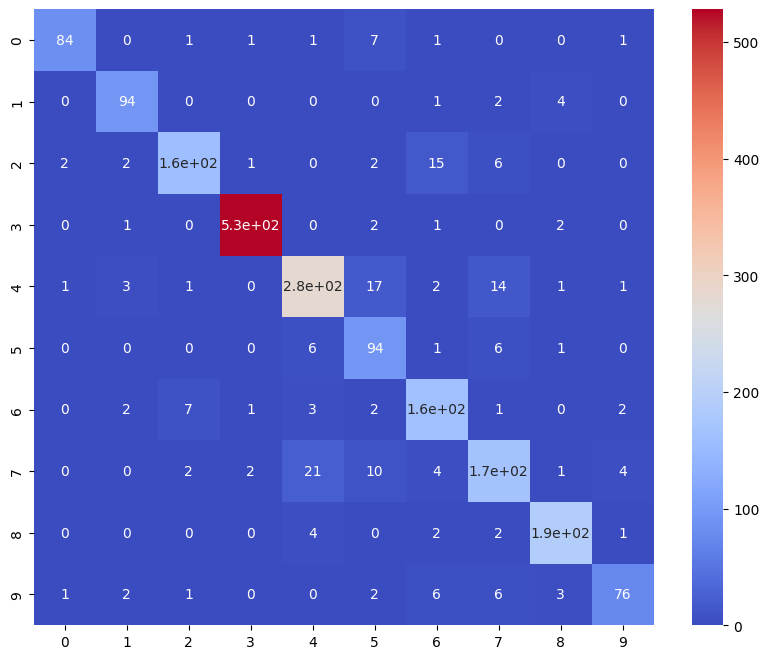

In [47]:
# Plot the confusion matrix as a heatmap for easier visual interpretation
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mobilenetv2, cmap='coolwarm', annot=True)

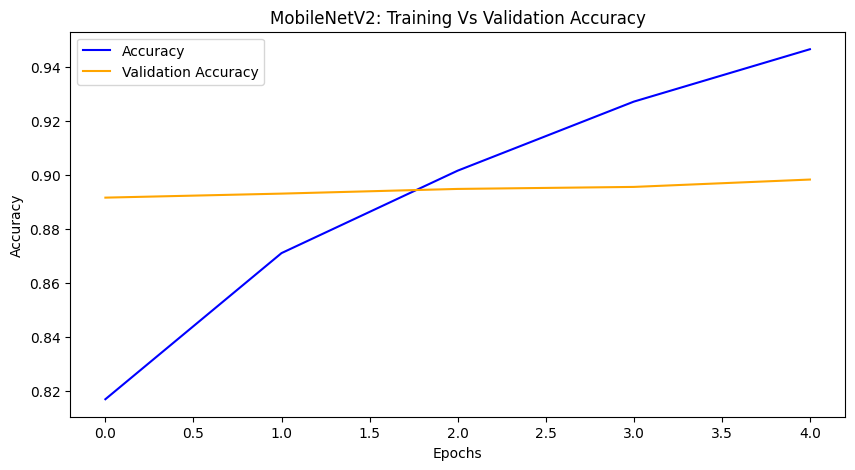

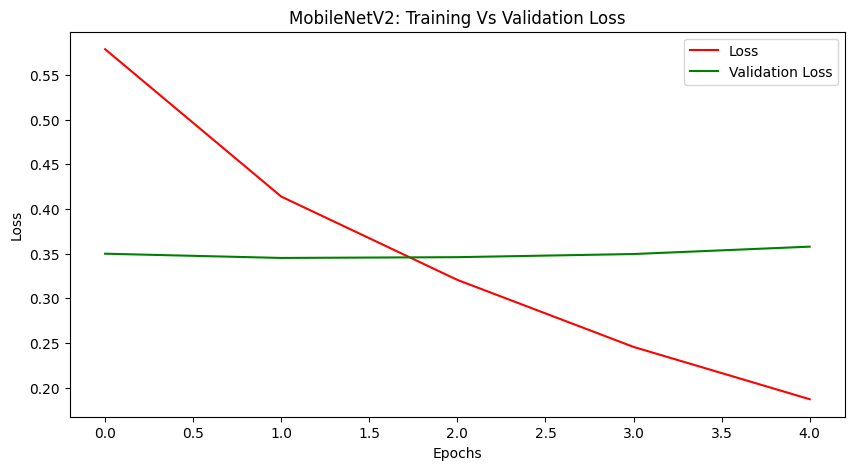

In [48]:
# MobileNetV2 Learning Curves
# Plot training and validation accuracy and loss to visualize learning behavior

# ---- Accuracy curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_mobilenetv2.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('MobileNetV2: Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_mobilenetv2.history['loss'], label='Loss', color='red')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss', color='green')
plt.title('MobileNetV2: Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.4 EfficientNetB0

- **Architecture**: EfficientNetB0 was employed as a modern backbone optimized for accuracy and efficiency.
- **Fine-Tuning**: Layers were selectively unfrozen to maximize transfer learning benefits.
- **Evaluation**: The model achieved the highest accuracy with the shortest training time.
- **Visualizations**: Curves confirmed fast and stable convergence.


### **Architecture**

Applies EfficientNetB0 for optimal accuracy-to-efficiency ratio.

In [49]:
def build_efficientnetb0_model(num_classes, input_shape, freeze_base=True):
    """
    Build an EfficientNetB0-based image classifier with a custom dense head.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shape : tuple
        Shape of input images (height, width, channels).
    freeze_base : bool, default True
        Whether to freeze the pretrained EfficientNetB0 backbone.

    Returns
    -------
    model : keras.Model
        Compiled Keras model ready for training.
    base_model : keras.Model
        The EfficientNetB0 backbone (pretrained), useful for fine-tuning or inspection.
    """

    # tf.keras.backend.clear_session()
    
    # Load pretrained EfficientNetB0 backbone without top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = not freeze_base

    # Build custom classification head
    x = Dense(128, activation='relu')(base_model.output)
    x = Dropout(0.5)(x) # Regularization
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x) # Regularization

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Assemble and compile model
    model = Model(inputs=base_model.input, outputs=output_layer)
    optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model

#### Model Complexity Overview

This section summarizes the architectural and computational characteristics of the EfficientNetB0-based transfer learning model.

| Component                  | Description                                                  |
|---------------------------|--------------------------------------------------------------|
| **Backbone**              | EfficientNetB0 (pretrained on ImageNet, `include_top=False`, `pooling='avg'`) |
| **Custom Head**           | Dense(128) → Dropout(0.5) → Dense(64) → Dropout(0.5) → Softmax |
| **Trainable Parameters**  | Depends on `freeze_base`; ~1.5M when frozen, ~5.3M when unfrozen |
| **Total Parameters**      | ~5.3M                                                        |
| **Input Shape**           | `(height, width, channels)` — e.g., `(224, 224, 3)`           |
| **Output Classes**        | `num_classes` (e.g., 10 for multiclass classification)        |
| **Regularization**        | Dropout (0.5) in both Dense layers                            |
| **Optimizer**             | Adam (`learning_rate=1e-3`)                                   |
| **Loss Function**         | Categorical Crossentropy                                      |
| **Metrics**               | Accuracy                                                      |

> Note: EfficientNetB0 offers a strong balance of accuracy and efficiency, making it ideal for deployment on resource-constrained devices. Fine-tuning can be enabled via `enable_fine_tuning()` to adapt deeper layers to domain-specific data.

In [50]:
train_ds, val_ds, test_ds = prepare_data_pipeline(
    train_dir,
    val_dir,
    test_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    model_type='efficientnetb0'
)

Found 14142 files belonging to 10 classes.
Found 4038 files belonging to 10 classes.
Found 2032 files belonging to 10 classes.


In [51]:
# Build the EfficientNetB0 model
efficientnetb0_model, base_model = build_efficientnetb0_model(10, input_shape)

# Display the model architecture, layer types, output shapes, and parameter counts
efficientnetb0_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 180, 180, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 180, 180, 3)       │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 180, 180, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 180, 180, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 181, 181, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 90, 90, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 90, 90, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 90, 90, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 90, 90, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 90, 90, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 90, 90, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,222,445 (16.11 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [52]:
# Record the start time to measure total training duration
start_time = time.time()

In [53]:
# Train the EfficientNetB0 model using the prepared training and validation datasets
history_efficientnetb0 = efficientnetb0_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('efficientnetb0')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6556 - loss: 1.0388  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 461s 247ms/step - accuracy: 0.7553 - loss: 0.7601 - val_accuracy: 0.9086 - val_loss: 0.2798 - learning_rate: 0.0010
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8443 - loss: 0.5181  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 310s 175ms/step - accuracy: 0.8519 - loss: 0.4893 - val_accuracy: 0.9185 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8703 - loss: 0.4227  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 294s 166ms/step - accuracy: 0.8747 - loss: 0.4093 - val_accuracy: 0.9222 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8873 - loss: 0.3669  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 297s 168ms/step - accuracy: 0.8899 - loss: 0.3604 - val_accuracy: 0.9272 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 285s 161ms/step - accuracy: 0.9014 - loss: 0.3237 - val_accuracy: 0.9257 - val_loss: 0.2514 - learning_rate: 0.0010


In [54]:
# Record the end time after training completes
end_time = time.time()

# Calculate total training duration in seconds
train_time_efficientnetb0 = end_time - start_time

In [71]:
print(f"Training time: {abs(train_time_efficientnetb0):.2f} seconds")

Training time: 1648.54 seconds


### **EfficientNetB0 Fine-tuning**

Unfreezes selected layers and retrains with a lower learning rate to improve performance.

In [56]:
# Enable fine-tuning by unfreezing the top 20 layers of the base model
efficientnetb0_model = enable_fine_tuning(
    efficientnetb0_model,
    base_model,
    unfreeze_layers=20,
    learning_rate=1e-5
)

In [57]:
# Train the fine-tuned ResNet50 model for 5 epochs using callbacks
history_efficientnetb0 = efficientnetb0_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks('efficientnetb0')
)

Epoch 1/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7559 - loss: 0.8701  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 347s 185ms/step - accuracy: 0.7700 - loss: 0.7861 - val_accuracy: 0.9168 - val_loss: 0.2773 - learning_rate: 1.0000e-05
Epoch 2/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8003 - loss: 0.6738  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 422s 239ms/step - accuracy: 0.8088 - loss: 0.6396 - val_accuracy: 0.9175 - val_loss: 0.2608 - learning_rate: 1.0000e-05
Epoch 3/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8282 - loss: 0.5728  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 442s 250ms/step - accuracy: 0.8296 - loss: 0.5604 - val_accuracy: 0.9210 - val_loss: 0.2502 - learning_rate: 1.0000e-05
Epoch 4/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8359 - loss: 0.5278  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 441s 249ms/step - accuracy: 0.8431 - loss: 0.5134 - val_accuracy: 0.9220 - val_loss: 0.2439 - learning_rate: 1.0000e-05
Epoch 5/5
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8428 - loss: 0.4916  

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 333s 188ms/step - accuracy: 0.8504 - loss: 0.4810 - val_accuracy: 0.9255 - val_loss: 0.2375 - learning_rate: 1.0000e-05


### **EfficientNetB0 Evaluation**

Evaluates model predictions using classification report and raw confusion matrix (numeric) after fine-tuning.

In [58]:
# Evaluate model performance on the test set
test_loss, test_acc = efficientnetb0_model.evaluate(test_ds)
print(f'EfficientNetB0 Test Loss: {test_loss}')
print(f"EfficientNetB0 Test Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.9222 - loss: 0.2343
EfficientNetB0 Test Loss: 0.2342635840177536
EfficientNetB0 Test Accuracy: 92.22%


In [60]:
# Generate predictions and compute evaluation metrics
y_pred_efficientnetb0 = efficientnetb0_model.predict(test_ds)
y_pred_efficientnetb0 = np.argmax(y_pred_efficientnetb0, axis=1)

# Confusion matrix and classification report
cm_efficientnetb0 = confusion_matrix(y_true, y_pred_efficientnetb0)
print(cm_efficientnetb0)
print('\n')
print(classification_report(y_true, y_pred_efficientnetb0))

254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step
[[ 88   0   3   0   0   5   0   0   0   0]
 [  0  96   0   3   0   0   1   0   0   1]
 [  0   0 172   1   0   1  11   1   0   0]
 [  0   0   0 528   0   1   1   1   3   0]
 [  0   1   1   0 286   8   2  19   3   1]
 [  3   0   0   1   4  97   0   3   0   0]
 [  2   1   8   0   1   0 163   0   1   4]
 [  0   0   3   0  20   5   1 176   1   4]
 [  0   0   0   1   1   1   1   0 194   1]
 [  1   1   2   2   0   3   7   5   2  74]]


              precision    recall  f1-score   support

           0       0.94      0.92      0.93        96
           1       0.97      0.95      0.96       101
           2       0.91      0.92      0.92       186
           3       0.99      0.99      0.99       534
           4       0.92      0.89      0.90       321
           5       0.80      0.90      0.85       108
           6       0.87      0.91      0.89       180
           7       0.86      0.84      0.85       210
           8       0.95      0.97   

### **EfficientNetB0 Evaluation Visualizations**

- Visualizes the confusion matrix as a heatmap for intuitive class-wise performance analysis.
- Plots training and validation accuracy/loss over epochs to visualize learning dynamics.

<Axes: >

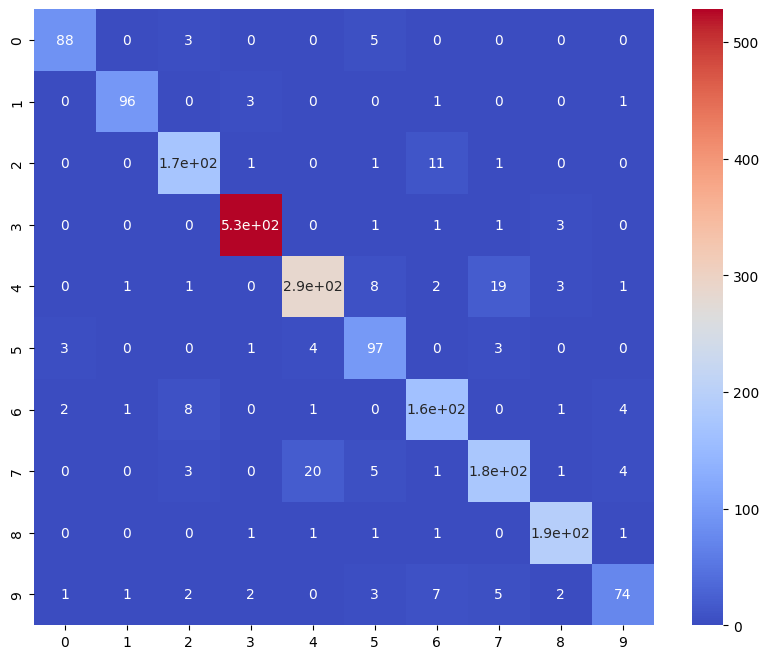

In [61]:
# Plot the confusion matrix as a heatmap for easier visual interpretation
plt.figure(figsize=(10, 8))
sns.heatmap(cm_efficientnetb0, cmap='coolwarm', annot=True)

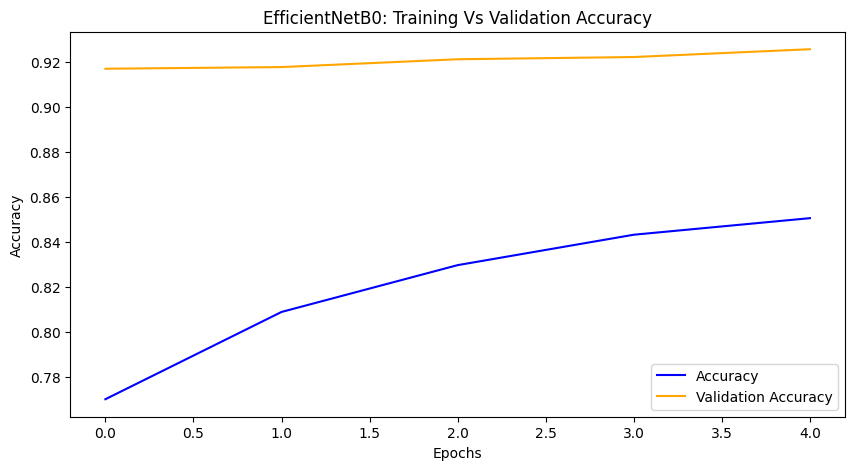

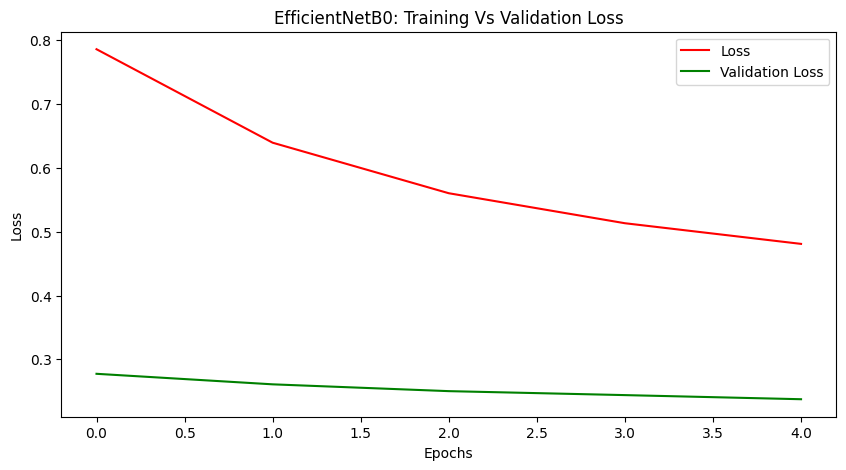

In [62]:
# EfficientNetB0 Learning Curves
# Plot training and validation accuracy and loss to visualize learning behavior

# ---- Accuracy curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnetb0.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history_efficientnetb0.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('EfficientNetB0: Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnetb0.history['loss'], label='Loss', color='red')
plt.plot(history_efficientnetb0.history['val_loss'], label='Validation Loss', color='green')
plt.title('EfficientNetB0: Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Compare Model Performance

All models were compared side-by-side in terms of accuracy and training time. Results demonstrated the superiority of transfer learning approaches, with EfficientNetB0 emerging as the most efficient and accurate model overall. 
Each model (Baseline CNN, ResNet50, MobileNetV2, EfficientNetB0) is trained using:

* Identical preprocessing
* Identical callbacks
* Identical evaluation metrics

This ensures a fair comparison.

In [64]:
results = [
    {
        'Model': 'Scratch CNN',
        'Accuracy': accuracy_score(y_true, y_pred_cnn),
        'Train Time': train_time_cnn,

    },
    {
        'Model': 'ResNet50',
        'Accuracy': accuracy_score(y_true, y_pred_resnet50),
        'Train Time': train_time_resnet50,
    },
    {
        'Model': 'MobileNetV2',
        'Accuracy': accuracy_score(y_true, y_pred_mobilenetv2),
        'Train Time': train_time_mobilenetv2,
    },
    {
        'Model': 'EfficientNetB0',
        'Accuracy': accuracy_score(y_true, y_pred_efficientnetb0),
        'Train Time': train_time_efficientnetb0,
    }
]

In [65]:
df_results = pd.DataFrame(results)
df_results.set_index(['Model'])

,Accuracy,Train Time
Model,,
Scratch CNN,0.432579,2808.874691
ResNet50,0.912402,4778.309657
MobileNetV2,0.902067,1764.534113
EfficientNetB0,0.922244,1648.540666


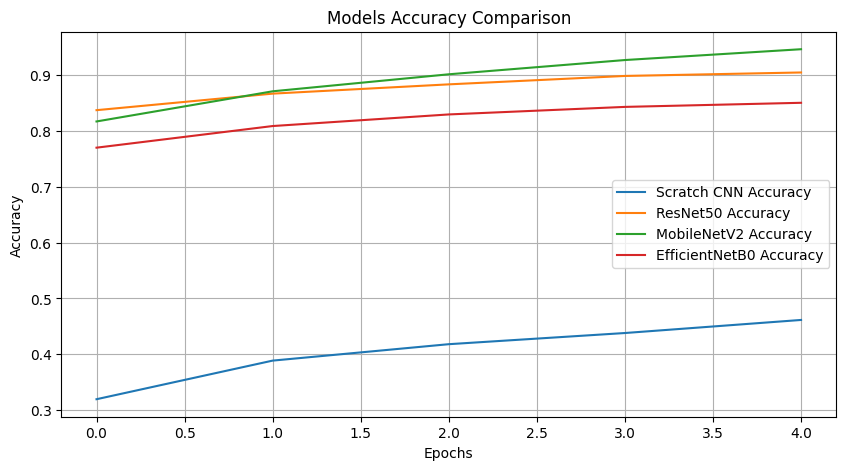

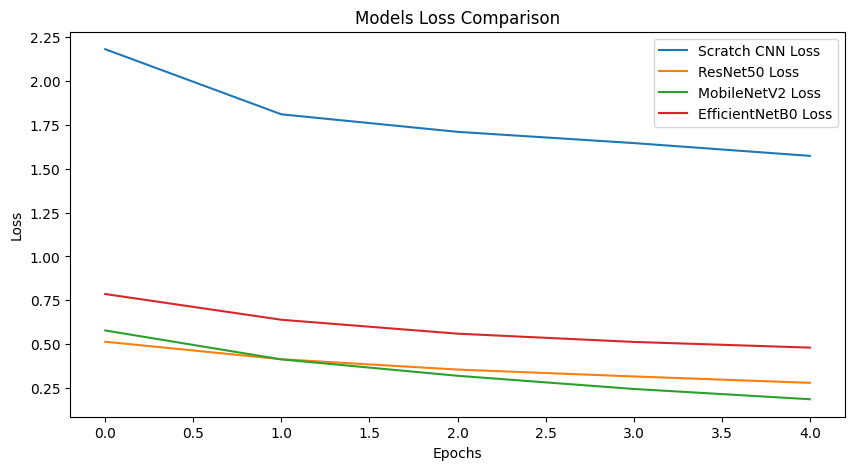

In [66]:
# ---- Accuracy Comparison ----
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='Scratch CNN Accuracy')
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Accuracy')
plt.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 Accuracy')
plt.plot(history_efficientnetb0.history['accuracy'], label='EfficientNetB0 Accuracy')
plt.title('Models Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='Scratch CNN Loss')
plt.plot(history_resnet50.history['loss'], label='ResNet50 Loss')
plt.plot(history_mobilenetv2.history['loss'], label='MobileNetV2 Loss')
plt.plot(history_efficientnetb0.history['loss'], label='EfficientNetB0 Loss')
plt.title('Models Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Quantitative Performance Analysis

The results clearly demonstrate the impact of transfer learning compared to training a model from scratch.

* The **Scratch CNN** achieves an accuracy of **43.3%**, indicating significant underfitting and limited feature extraction capability when trained on a relatively small dataset.
* All **transfer learning models exceed 90% accuracy**, highlighting the effectiveness of pretrained ImageNet features.
* **EfficientNetB0** achieves the **highest accuracy (92.2%)** while also requiring the **least training time**, making it the most - accuracy-efficient model overall.
* **MobileNetV2** offers an excellent trade-off between accuracy and computational efficiency, performing comparably to ResNet50 at less than half the training cost.
* **ResNet50**, while highly accurate, incurs the highest training time and does not outperform EfficientNetB0.

These findings suggest that **modern lightweight architectures can outperform deeper, heavier models when properly fine-tuned**.

# 7. Training Curves Analysis

### Individual Model Accuracy & Loss Curves

Each model's training and validation accuracy and loss curves were analyzed to understand learning dynamics:

* **Scratch CNN** shows slow convergence and early performance saturation, indicating underfitting.
* **Transfer learning models** converge rapidly within a few epochs, with smooth loss reduction and stable validation accuracy.
* Minimal gaps between training and validation curves suggest effective regularization and good generalization.

### Combined Model Comparison

The combined accuracy and loss curves highlight clear performance separation:

* Transfer learning models dominate from the earliest epochs.
* **EfficientNetB0** demonstrates the fastest and most stable convergence.
* The Scratch CNN consistently lags behind, reinforcing the quantitative results.

These visual trends reinforce the superiority of transfer learning for rapid and stable optimization.

# 8. Conclusion and Insights

The comparative experiments highlight the decisive impact of **transfer learning** over training models from scratch on limited datasets.  

- The **Scratch CNN** illustrates the challenges of building deep networks without pretrained features, achieving only **43.3% accuracy** and requiring long training times.  
- All **transfer learning models surpass 90% accuracy**, confirming the value of leveraging ImageNet‑trained backbones for robust feature extraction.  
- **EfficientNetB0** consistently delivers the **best trade‑off**, achieving the **highest accuracy (92.2%)** with the **shortest training time**, making it the most production‑efficient choice.  
- **MobileNetV2** demonstrates excellent balance, offering near‑ResNet50 accuracy at less than half the computational cost, making it highly suitable for deployment on resource‑constrained devices.  
- **ResNet50**, while powerful, incurs the highest training cost and does not outperform EfficientNetB0, underscoring that deeper architectures are not always the most efficient option.

## Key Insights
- **Transfer learning dramatically improves performance** for small and medium‑sized datasets.  
- **Modern lightweight architectures (EfficientNet, MobileNet)** can outperform heavier models when fine‑tuned effectively.  
- **Model selection should consider both accuracy and efficiency**, as deployment environments often demand a balance between predictive power and computational cost.  

> Overall, this notebook demonstrates a **production‑aware, comparative deep learning workflow** that not only benchmarks accuracy but also evaluates efficiency, offering actionable guidance for real‑world image classification tasks.

# 9. Future Improvements

While the current experiments provide clear insights into model performance, several enhancements could further strengthen this workflow:

* **Extended Training & Fine-Tuning Schedules**  
  Implement longer training runs with staged unfreezing of backbone layers to maximize transfer learning benefits.

* **Inference-Time Benchmarking**  
  Measure latency, throughput, and memory usage to evaluate deployment feasibility across different hardware environments.

* **Model Export & Deployment**  
  Package models into production-ready formats (e.g., TensorFlow SavedModel, ONNX) for integration into real-world applications.

* **Additional Metrics**  
  Track precision, recall, F1-score, and confusion matrices to gain deeper insight into class-level performance.

* **Cross-Model Comparison**  
  Extend benchmarking to include FLOPs, parameter counts, and energy efficiency for a holistic view of trade-offs.

These improvements would transform the notebook from a comparative study into a **deployment-ready ML pipeline**, bridging the gap between research and production.